# Advanced Lane Finding Project

The steps of this project are:

- Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
- Apply a distortion correction to raw images.
- Use color transforms, gradients, etc., to create a thresholded binary image.
- Apply a perspective transform to rectify binary image ("birds-eye view").
- Detect lane pixels and fit to find the lane boundary.
- Determine the curvature of the lane and vehicle position with respect to center.
- Warp the detected lane boundaries back onto the original image.
- Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
- Proccess project videos

In [1]:
import numpy as np
import cv2
import glob
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from collections import deque
%matplotlib inline


# CAMERA CALIBRATION UNDISTORT


Load a list of chess board images taken with a camera, and use them to find the distortion matrix

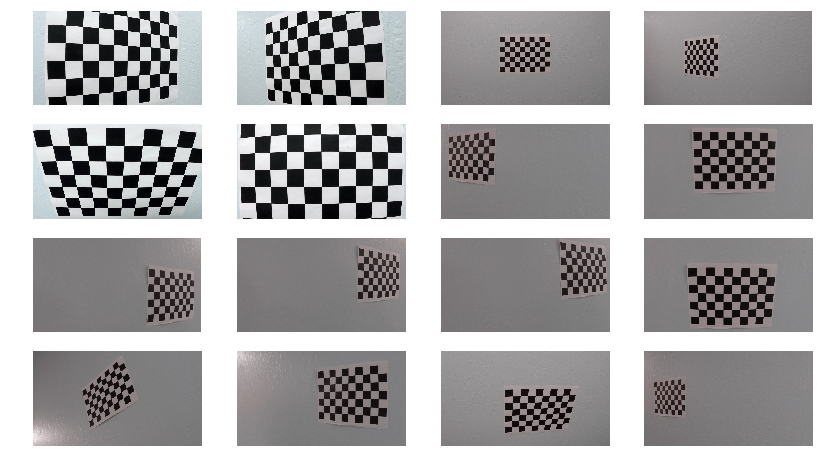

In [15]:
test_img = mpimg.imread('test_images/test4.jpg')
test_imgs = [i for i in glob.iglob('test_images/*')]
camera_images = [cv2.imread(i) for i in glob.iglob('camera_cal/calibration*.jpg')]
camera_test_images = [cv2.imread(i) for i in glob.iglob('camera_cal/test_image*.jpg')]

f, ax = plt.subplots(4, 4, figsize=(14, 8))

for i in range(4):
    for e in range(4):
        ax[i,e].imshow(camera_images[i*4 + e])
        ax[i,e].axis('off')

plt.show()

In [17]:
nx = 9
ny = 6

# Camera calibration using chess board images
def camera_calibration():
    objpoints = []
    imgpoints = []
    
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1, 2)

    # Find chess board corners
    for img, i in zip(camera_images, range(len(camera_images))):
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        
        # Append points from successful findChessboardCorners
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)    
    
    # Calculate camera distortion
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, camera_test_images[0].shape[::-1][1:3], None, None)        
    
    return ret, mtx, dist

ret, mtx, dist = camera_calibration()

# Unidistor image
def undistort_img(img):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst


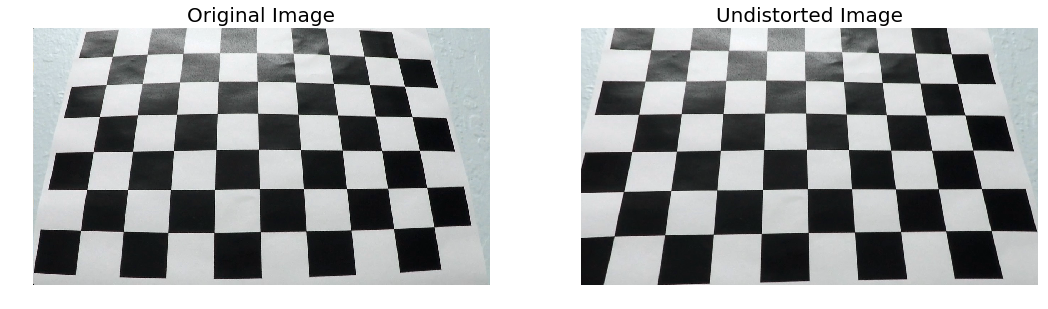

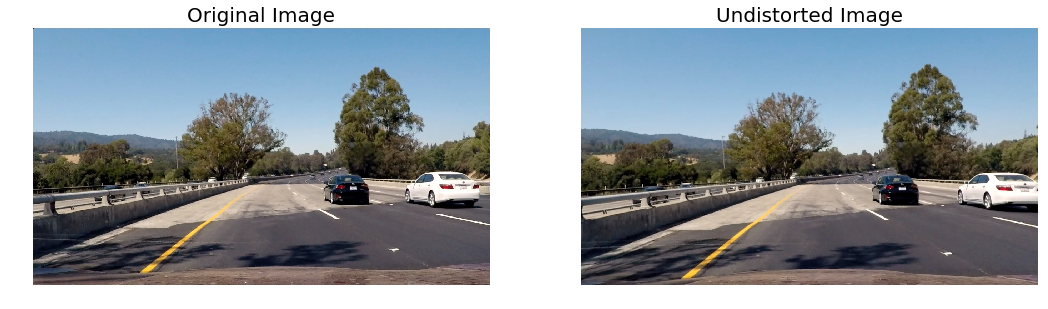

In [4]:
def test_distortion(img):
    f, ax = plt.subplots(len(camera_test_images), 2, figsize=(18, 5))
    dst = undistort_img(img)
    ax[0].imshow(img)
    ax[0].axis('off')
    ax[0].set_title('Original Image', fontsize=20)
    ax[1].imshow(dst)
    ax[1].axis('off')
    ax[1].set_title('Undistorted Image', fontsize=20)
    plt.show()

test_distortion(camera_test_images[0])
test_distortion(test_img)

In the chess board is possible to check the difference between the original and the undistorted image easily, in the highway image you can check the position of white car to realize the difference.

# SOBEL GRADIENT ABSOLUTE/MAGNITUDE/DIRECTION THRESHOLD

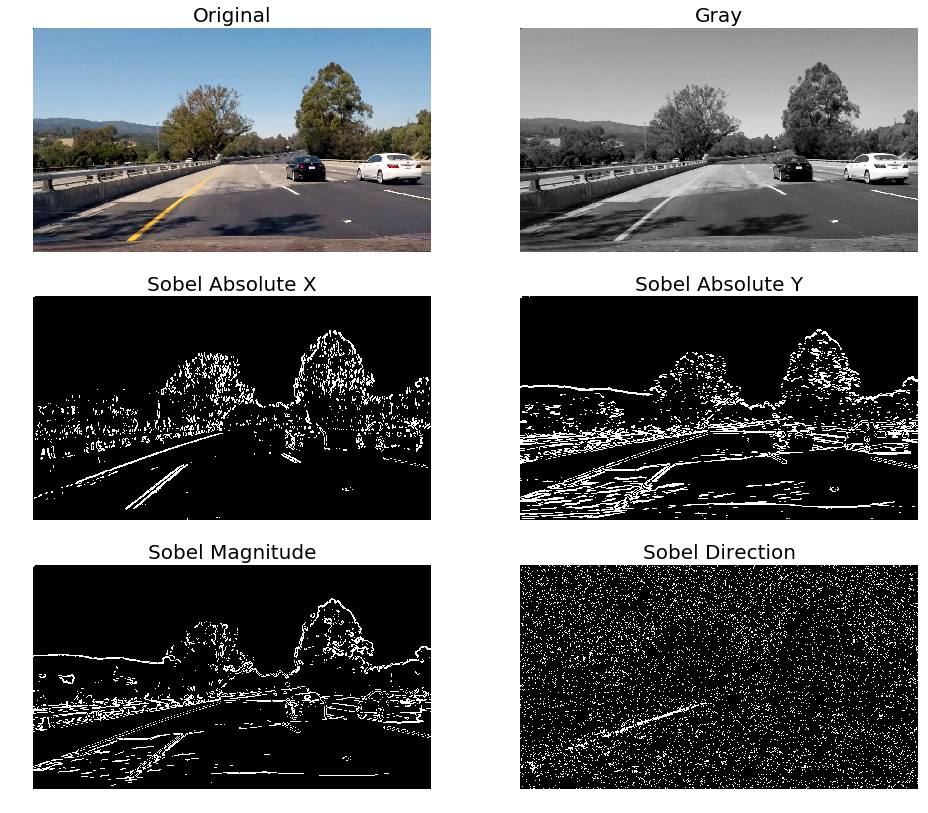

In [20]:
import matplotlib.image as mpimg

# Auxiliar function to apply a filter to image
def apply_threshold(img, thresh):
    binary_output = np.zeros_like(img)
    binary_output[(img >= thresh[0]) & (img <= thresh[1])] = 1
    return binary_output

# Sobel absolute threshold
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    else:
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))

    return apply_threshold(scaled_sobel, thresh)

# Sobel magnitude threshold
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    
    return apply_threshold(gradmag, mag_thresh)

# Sobel direction threshold
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))

    return apply_threshold(absgraddir, thresh)

ksize = 21
threshX = (30, 100)
threshY = (30, 100)
threshMag = (50, 100)
threashDir = (1.2, 1.3)

gray = cv2.cvtColor(test_img, cv2.COLOR_RGB2GRAY)

gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=ksize, thresh=threshX)
grady = abs_sobel_thresh(gray, orient='y', sobel_kernel=ksize, thresh=threshY)
mag_binary = mag_thresh(gray, sobel_kernel=ksize, mag_thresh=threshMag)
dir_binary = dir_threshold(gray, sobel_kernel=ksize, thresh=threashDir)

f, ax = plt.subplots(3, 2, figsize=(16, 14))

def plt_img(ix, iy, ax, title, image):
    ax[ix,iy].imshow(image, cmap='gray')
    ax[ix,iy].axis('off')
    ax[ix, iy].set_title(title, fontsize=20)

plt_img(0,0, ax, 'Original', test_img)
plt_img(0,1, ax, 'Gray', gray)
plt_img(1,0, ax, 'Sobel Absolute X', gradx)
plt_img(1,1, ax, 'Sobel Absolute Y', grady)
plt_img(2,0, ax, 'Sobel Magnitude', mag_binary)
plt_img(2,1, ax, 'Sobel Direction', dir_binary)
    
plt.show()


# Color Spaces

Checking what color spaces can detect the lane lines best:

- RGB: It's possible to use the RED channel, the lane line are visible
- HSV: It's possible to use the V channel, both lines looks good.
- HLS: It's possible to use the S channel here, both lines looks good.


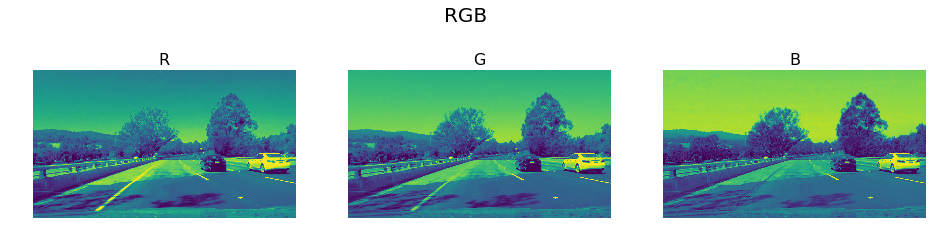

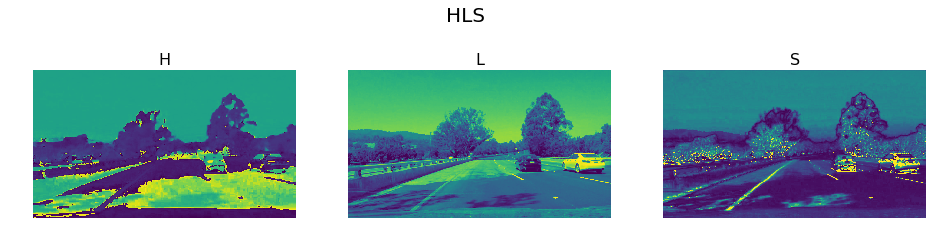

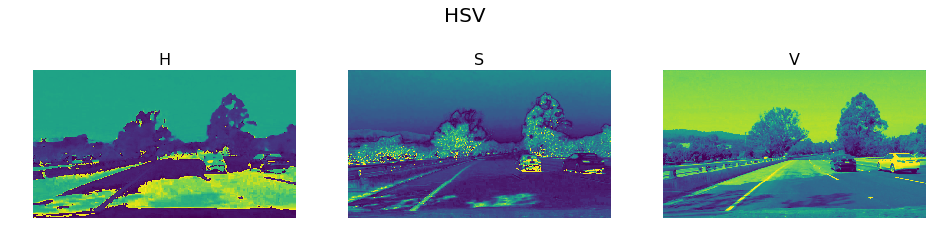

In [6]:
def color_space(title, img):
    subtitles = list(title)
    one = img[:,:,0]
    two = img[:,:,1]
    three = img[:,:,2]
    
    f, ax = plt.subplots(1, 3, figsize=(16, 4))
    
    ax[0].imshow(one)
    ax[0].axis('off')
    ax[0].set_title(subtitles[0], fontsize=16)
    
    ax[1].imshow(two)
    ax[1].axis('off')
    ax[1].set_title(subtitles[1], fontsize=16)

    ax[2].imshow(three)
    ax[2].axis('off')
    ax[2].set_title(subtitles[2], fontsize=16)
    
    plt.suptitle(title, fontsize=20)
    plt.show()

hls_image = cv2.cvtColor(test_img, cv2.COLOR_RGB2HLS)
hsv_image = cv2.cvtColor(test_img, cv2.COLOR_RGB2HSV)
    
color_space('RGB', test_img)
color_space('HLS', hls_image)
color_space('HSV', hsv_image)


# Perspective Transform

The idea is to create a "birds-eye view" based on a perspective transformation of the images using some defined source and destination points.

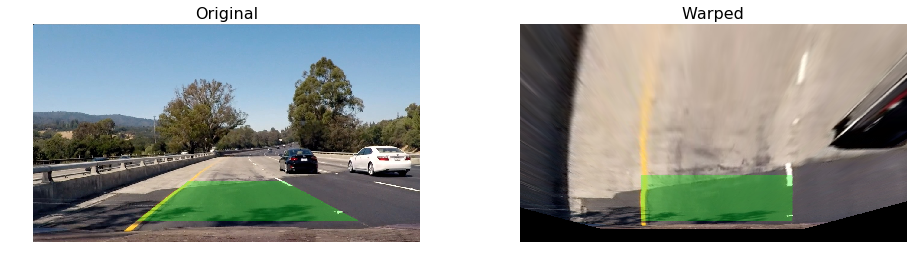

In [7]:
# Perspective transform function
def warp_img(src_points, dst_points, img):
    M = cv2.getPerspectiveTransform(src_points, dst_points)
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
    return warped

# Source and destination points for perspective transform
src_p = [ [341, 650], [1078, 650], [832, 520], [511, 520]]
dst_p = [ [400, 650], [900, 650], [900, 500], [400, 500]]

overlay = np.copy(test_img)
test_warp = np.copy(test_img)

pts = np.array(src_p, np.int32)
pts = pts.reshape((-1,1,2))
cv2.fillPoly(overlay, [pts], (0,255,0, ))

alpha = 0.3
cv2.addWeighted(overlay, alpha, test_warp, 1 - alpha, 0, test_warp)

warped = warp_img(np.float32(src_p), np.float32(dst_p), test_warp)

f, ax = plt.subplots(1, 2, figsize=(16, 4))

ax[0].imshow(test_warp)
ax[0].axis('off')
ax[0].set_title('Original', fontsize=16)

ax[1].imshow(warped)
ax[1].axis('off')
ax[1].set_title('Warped', fontsize=16)
      

#  Image Process Pipeline

The idea is to apply a set of the previous defined transformation to process the image that could help to identify more easily the lane lines.

The general steps are the next:

- Camera calibration (just one time)
- Undistort image
- Apply a color transformation
- Apply a gradient threshold transformation using sobel
- Apply perspective transformation


Once the image pass through this pipeline is ready for the lane line detection

## Pipeline

This was one of the most important parts of the project. I tried to create a pipeline that was good in normal and light conditions.

For that i try different things but at the end i did the following:

- An sobel absolute X transformation, using a **very low min threshold**, making this value low allows to capture more information, that is useful when is hard to detect the lane line because of ligth conditions.
- A sobel direction transformation used to reinforce the values of the lane lines using a **small threshold** to capture important parts of the image.
- Use the V channel of HSV to capture the lane lines, to reinforce the lane line in **normal conditions** (with ligther conditions it detects too much information)

The combination of the low threshold sobel absolute X transformation to detect hard ligth conditions, and use the sobel direction and V chanel to reinforce the lane line, make this pipeline works good in the three videos.




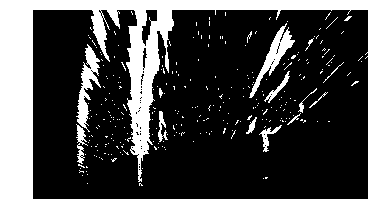

In [21]:
def img_proc_pipeline(img):
    
    # Undistort
    undist_img = undistort_img(img)
    
    # HLS color space
    hls_image = cv2.cvtColor(undist_img, cv2.COLOR_RGB2HLS)
    s_channel = hls_image[:,:,2]
    
    # HLS color spaces_channel
    hsv_image = cv2.cvtColor(undist_img, cv2.COLOR_RGB2HSV)
    v_channel = hsv_image[:,:,2]
    
    # Sobel transformation using only x orientation
    ksize = 21
    threshold = (10, 100)
    sobel_binary = abs_sobel_thresh(s_channel, orient='x', sobel_kernel=ksize, thresh=threshold)
    
    # Sobel transformation using only x orientation
    ksize = 21
    threashDir = (1.27, 1.3)
    dir_binary = dir_threshold(v_channel, sobel_kernel=ksize, thresh=threashDir)
    
    # Threshold color channel
    v_thresh_min = 150
    v_thresh_max = 255
    v_channel_binary = apply_threshold(v_channel, (v_thresh_min, v_thresh_max))
        
    # Combine color and gradient
    combined_binary = np.zeros_like(sobel_binary)
    combined_binary[((sobel_binary == 1) | (dir_binary == 1)) & (v_channel_binary == 1) ] = 1

    # Perspective transformation
    warped = warp_img(np.float32(src_p), np.float32(dst_p), combined_binary)
    
    return warped

    
proccesed_img = img_proc_pipeline(test_img)

plt.imshow(proccesed_img, cmap='gray')
plt.axis('off')
plt.show()
    

# Finding Lane Line

The algorithm for the lane line detection goes as follows:

1. It detects the columns of the image that has more data to find the centroids where the left and right lane are.
2. Using the pre-calculated centroids, now is time to use a small window to identify the real points on each line. The window moves through the image detecting all the points on each lane.
3. Once all the points are detected is used and algorithm that can use those points to construct a mathematical function that fit all those points.
4. Using that function now is time to draw on the image the detected points on each line and draw the polynomial function that fit those points.


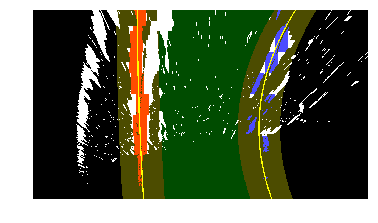

In [22]:
warped = proccesed_img
window_width = 50 
window_height = 80
margin = 80

# Auxiliary function that divides the images in level to help to find the centroids of each line
def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

# Function to calculate the centroids of the lane line (centrail points for each line)
def find_window_centroids(image, window_width, window_height, margin):
    window_centroids = [] 
    window = np.ones(window_width) 
        
    l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    
    window_centroids.append((l_center,r_center))
    
    for level in range(1,(int)(image.shape[0]/window_height)):
        image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
        
        conv_signal = np.convolve(window, image_layer)
        offset = window_width/2
        l_min_index = int(max(l_center+offset-margin,0))
        l_max_index = int(min(l_center+offset+margin,image.shape[1]))
        if np.sum(conv_signal[l_min_index:l_max_index]) != 0:
            l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        r_min_index = int(max(r_center+offset-margin,0))
        r_max_index = int(min(r_center+offset+margin,image.shape[1]))
        if np.sum(conv_signal[r_min_index:r_max_index]) != 0:
            r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        window_centroids.append((l_center,r_center))

    return window_centroids

# Use the centroids to find each line points and calculate polynomial function that fit them all
def find_lines(warped, window_centroids):
    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)

    # Go through each level and draw the windows 	
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
        l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
        r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)

        # Add graphic points from window mask here to total pixels found 
        l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
        r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    l_points_ind = np.where((l_points == 255) & (warped == 1) )
    r_points_ind = np.where((r_points == 255) & (warped == 1))
    
    if l_points_ind[0].size == 0 or r_points_ind[0].size == 0:
        return None, None, None, None, None

    left_fit = np.polyfit(l_points_ind[0], l_points_ind[1], 2)
    right_fit = np.polyfit(r_points_ind[0], r_points_ind[1], 2)
    
    output = np.dstack((warped, warped, warped))*255
    output[l_points_ind[0], l_points_ind[1]] = [255, 0, 0]
    output[r_points_ind[0], r_points_ind[1]] = [0, 0, 255]

    ploty = np.int32(np.linspace(0, output.shape[0]-1, output.shape[0] ))
    left_fitx = np.int32(left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2])
    right_fitx = np.int32(right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2])
        
    return l_points_ind, r_points_ind, left_fitx, right_fitx, ploty

# Draw all the results on a warped image
def draw_fitting_results(warped, l_points_ind, r_points_ind, left_fitx, right_fitx ):
    
    if l_points_ind is None:
        return np.dstack((warped, warped, warped))*255
    
    output = np.dstack((warped, warped, warped))*255
    output[l_points_ind[0], l_points_ind[1]] = [255, 0, 0]
    output[r_points_ind[0], r_points_ind[1]] = [0, 0, 255]
    window_img = np.zeros_like(output)
    ploty = np.int32(np.linspace(0, output.shape[0]-1, output.shape[0] ))

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))

    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    center_windows1 = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    center_windows2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    center_pts = np.hstack((center_windows1, center_windows2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([center_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (255,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (255,255, 0))
    result = cv2.addWeighted(output, 1, window_img, 0.3, 0)
    
    x_poly_l = np.reshape(left_fitx, (-1, 1))
    x_poly_r = np.reshape(right_fitx, (-1, 1))
    y_poly_l = np.reshape(ploty, (-1, 1))
    
    pts_l = np.reshape(np.concatenate((x_poly_l, y_poly_l), axis=1), (-1,1,2))
    pts_r = np.reshape(np.concatenate((x_poly_r, y_poly_l), axis=1), (-1,1,2))
    
    
    cv2.polylines(result, np.int32([pts_l]), False, (255,255,0),3)
    cv2.polylines(result, np.int32([pts_r]), False, (255,255,0),3)
    
    return result
    
window_centroids = find_window_centroids(warped, window_width, window_height, margin)
l_points_ind, r_points_ind, left_fitx, right_fitx, ploty = find_lines(warped, window_centroids)
result = draw_fitting_results(warped, l_points_ind, r_points_ind, left_fitx, right_fitx)


# Display the final results
plt.imshow(result)
plt.axis('off')
plt.show()

# Draw the Detected Lane Back onto the Original Image

Using the detected points now is time to draw back on the image where we have just calculated that are the right and left lines.

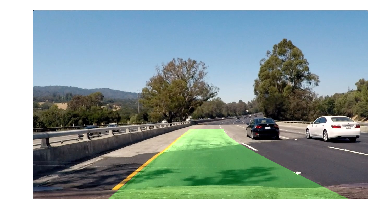

In [24]:
def draw_lane(img, warped, ploty, left_fitx,  right_fitx):
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    newwarp = warp_img(np.float32(dst_p), np.float32(src_p), color_warp)
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    return result

result = draw_lane(test_img, warped, ploty, left_fitx,  right_fitx)

plt.imshow(result)
plt.axis('off')
plt.show()


# Radius of Curvature and Distance from Lane Center Calculation

In [25]:
# Method to determine radius of curvature and distance from lane center 
# based on binary image, polynomial fit, and L and R lane pixel indices

ym_per_pix = 3.048/100
xm_per_pix = 3.7/378

def calc_curv_rad_and_center_dist(warped, left_fitx,  right_fitx, ploty):
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    y_eval = warped.shape[0]
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad/1000, right_curverad/1000

def distance_from_center(bin_img, left_fitx,  right_fitx, ploty):

    left_fit_m = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_m = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)

    xMax = bin_img.shape[1]*xm_per_pix
    yMax = bin_img.shape[0]*ym_per_pix
    vehicleCenter = xMax / 2
    lineLeft = left_fit_m[0]*yMax**2 + left_fit_m[1]*yMax + left_fit_m[2]
    lineRight = right_fit_m[0]*yMax**2 + right_fit_m[1]*yMax + right_fit_m[2]
    lineMiddle = lineLeft + (lineRight - lineLeft)/2
    diffFromVehicle = lineMiddle - vehicleCenter

    return diffFromVehicle

center_dist = distance_from_center(warped, left_fitx,  right_fitx, ploty)
rad_l, rad_r = calc_curv_rad_and_center_dist(warped, left_fitx,  right_fitx, ploty)


print('Distance from lane center for example:', center_dist, 'm')
print('Radius of curvature for example:', rad_l, 'km,', rad_r, 'km')


Distance from lane center for example: 0.265434353998 m
Radius of curvature for example: 0.976366126836 km, 0.0710300478529 km


# Process Test images

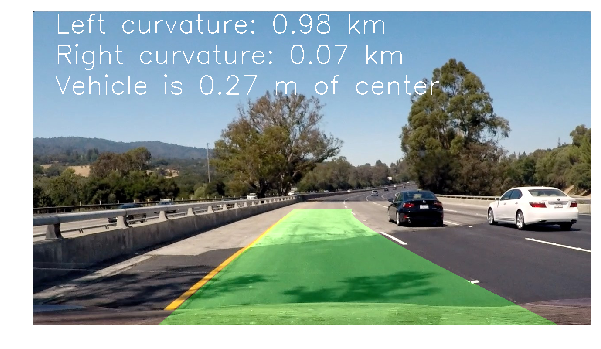

In [13]:
queue = deque( maxlen=10 )

def get_avg_fit():
    left_fitx = np.round( np.mean(np.array(queue)[:,0], axis=0))
    right_fitx = np.round( np.mean(np.array(queue)[:,1], axis=0))
    ploty = np.round( np.mean(np.array(queue)[:,2], axis=0))
    return left_fitx, right_fitx, ploty

def process_image(img):
    warped_img = img_proc_pipeline(img)
    
    window_centroids = find_window_centroids(warped_img, window_width, window_height, margin)
    
    _, _, left_fitx, right_fitx, ploty = find_lines(warped_img, window_centroids)
    
    if left_fitx is None and len(queue) == 0:
        return img
    
    if left_fitx is not None:
        queue.append((left_fitx, right_fitx, ploty))
    
    left_fitx, right_fitx, ploty = get_avg_fit()
    
    unwarp_img = draw_lane(img, warped, ploty,  left_fitx,  right_fitx)
    
    center_dist = distance_from_center(warped, left_fitx,  right_fitx, ploty)
    rad_l, rad_r = calc_curv_rad_and_center_dist(warped, left_fitx,  right_fitx, ploty)

    # Draw info
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontColor = (255, 255, 255)
    fontScale = 2
    cv2.putText(unwarp_img, 'Left curvature: {:.2f} km'.format(rad_l), (50, 50), font, fontScale, fontColor, 2)
    cv2.putText(unwarp_img, 'Right curvature: {:.2f} km'.format(rad_r), (50, 120), font, fontScale, fontColor, 2)
    cv2.putText(unwarp_img, 'Vehicle is {:.2f} m of center'.format(center_dist), (50, 190), font, fontScale, fontColor, 2)
    
    return unwarp_img

queue.clear()
plt.figure(figsize=(10,10))
plt.imshow(process_image(test_img))
plt.axis('off')
plt.show()
queue.clear()


# Videos

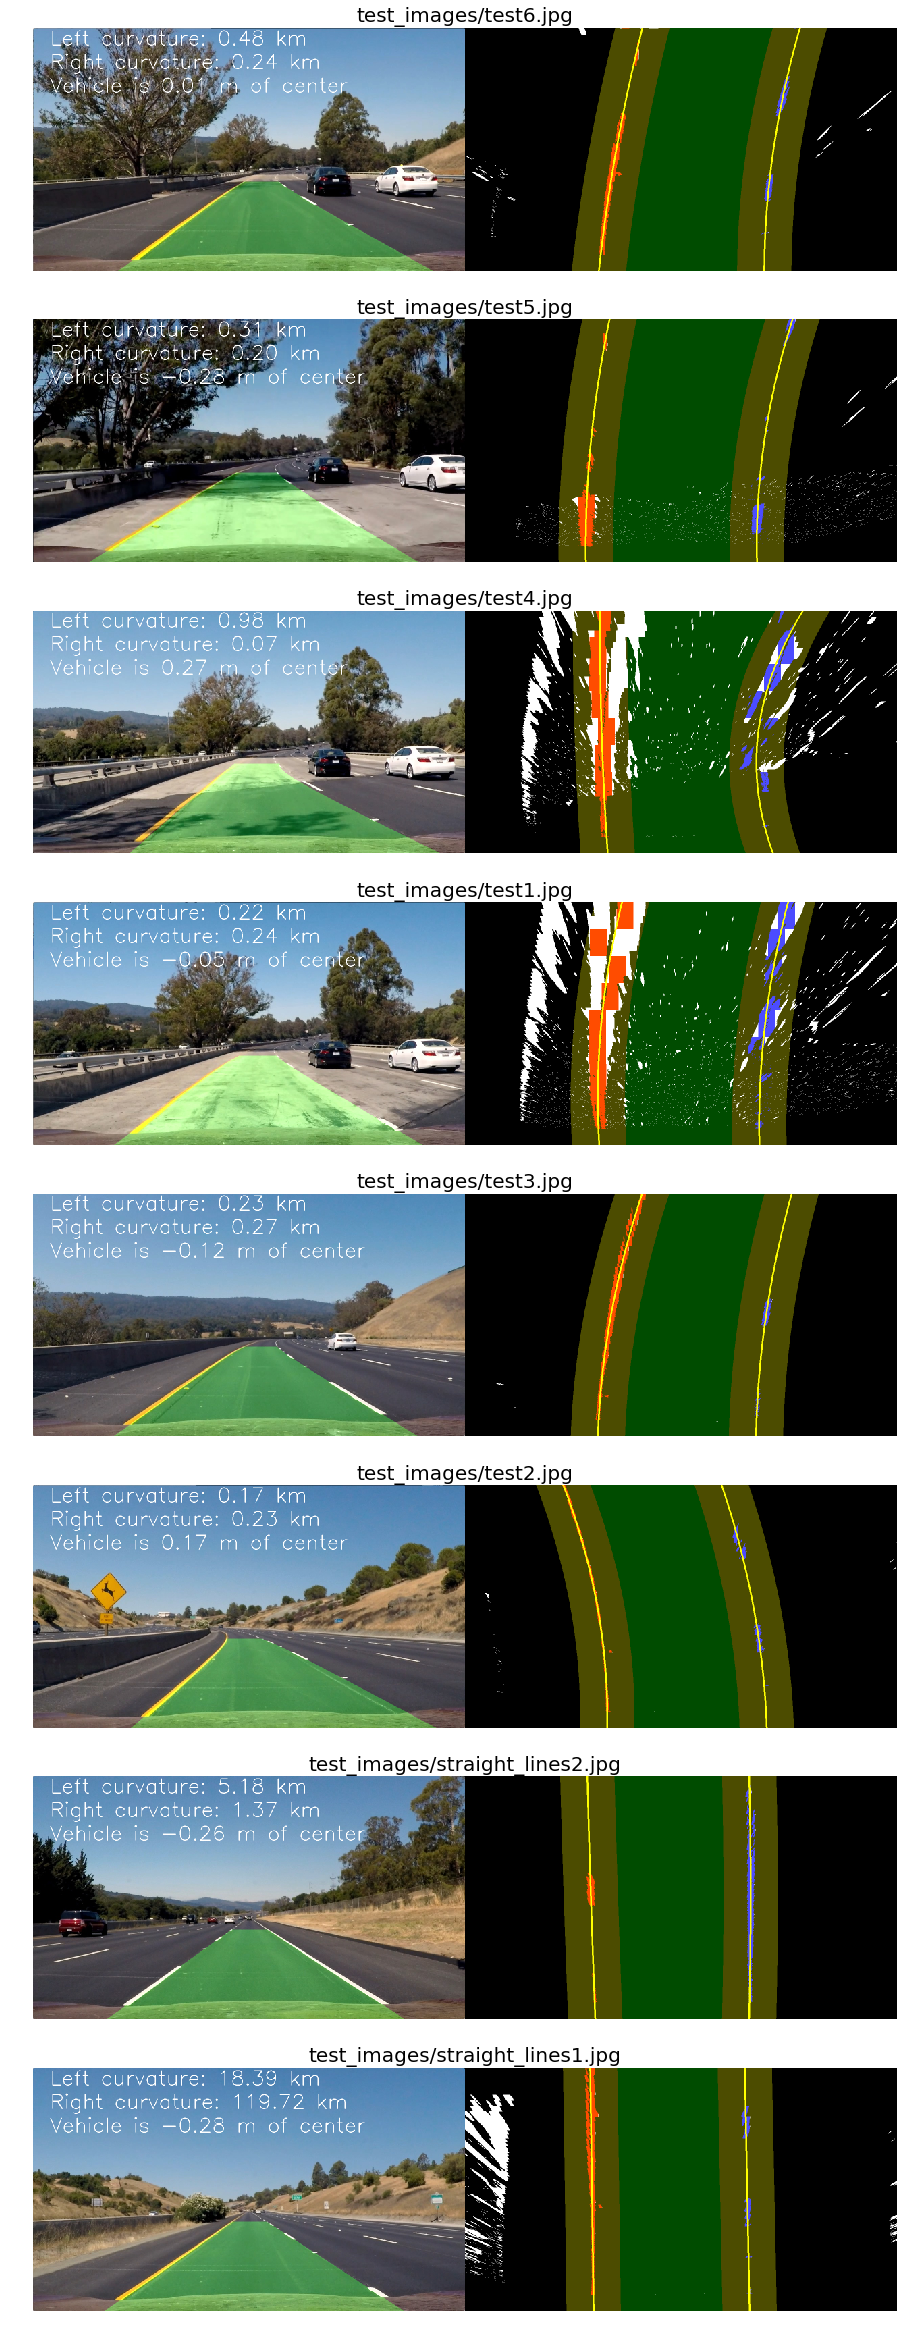

In [16]:
def process_image_vid(img):
    warped_img = img_proc_pipeline(img)
    
    window_centroids = find_window_centroids(warped_img, window_width, window_height, margin)
    
    l_points_ind, r_points_ind, left_fitx, right_fitx, ploty = find_lines(warped_img, window_centroids)
    
    if left_fitx is None and len(queue) == 0:
        return img
    
    if left_fitx is not None:
        queue.append((left_fitx, right_fitx, ploty))
    
    left_fitx, right_fitx, ploty = get_avg_fit()
    
    unwarp_img = draw_lane(img, warped_img, ploty,  left_fitx,  right_fitx)
    
    center_dist = distance_from_center(warped, left_fitx,  right_fitx, ploty)
    rad_l, rad_r = calc_curv_rad_and_center_dist(warped_img, left_fitx,  right_fitx, ploty)

    # Draw info
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontColor = (255, 255, 255)
    fontScale = 2
    cv2.putText(unwarp_img, 'Left curvature: {:.2f} km'.format(rad_l), (50, 50), font, fontScale, fontColor, 2)
    cv2.putText(unwarp_img, 'Right curvature: {:.2f} km'.format(rad_r), (50, 120), font, fontScale, fontColor, 2)
    cv2.putText(unwarp_img, 'Vehicle is {:.2f} m of center'.format(center_dist), (50, 190), font, fontScale, fontColor, 2)
    
    
    bin_fit_img = draw_fitting_results(warped_img, l_points_ind, r_points_ind, left_fitx, right_fitx)
    
    unwarp_img_scaled = cv2.resize(unwarp_img, (0,0), fx=0.5, fy=0.5)
    bin_fit_img_scaled = cv2.resize(bin_fit_img, (0,0), fx=0.5, fy=0.5)
    
    final = np.zeros((int(img.shape[0]/2), int(img.shape[1]), 3), dtype=np.uint8)
    final[:,0:int(final.shape[1]/2)] = unwarp_img_scaled
    final[:,int(final.shape[1]/2):final.shape[1]] = bin_fit_img_scaled
                         
    return final

f, ax = plt.subplots(len(test_imgs), 1, figsize=(16, 42))

for ix in range(len(test_imgs)):
    file_name = test_imgs[ix]
    ax[ix].imshow(process_image_vid(mpimg.imread(file_name)), cmap='gray')
    ax[ix].axis('off')
    ax[ix].set_title(file_name, fontsize=20)
    
    queue.clear()

plt.show()



In [294]:
from collections import deque

def process_video(video, video_output):
    """ Process frames of video using the process image function to draw lane lines"""
    queue.clear()
    clip1 = VideoFileClip(video)
    #clip1 = VideoFileClip(video).subclip(10,15)
    clip = clip1.fl_image(process_image_vid)
    clip.write_videofile(video_output, audio=False, verbose=False, progress_bar=False)

process_video("project_video.mp4", 'output_videos/project_video.mp4')
process_video("challenge_video.mp4", 'output_videos/challenge_video.mp4')
process_video("harder_challenge_video.mp4", 'output_videos/harder_challenge_video.mp4')


  UserWarning)







